In [1]:
import jax
#jax.config.update('jax_platform_name', 'cpu')
import numpy as np
import jax.numpy as jnp
from emlp_jax.equivariant_subspaces import T
from emlp_jax.groups import *
from emlp_jax.datasets import BrokenRubiksCube,InvertedCube
from emlp_jax.mlp import uniform_allocation

In [9]:
#G = ZksZnxZn(2,3)
#G = ZnxZn(4)
#G = S(7)
G= SO2eR3()
#G = Z(5)
#G=S(10)
#G = RubiksCube()
#G=SO(3)
#G=SO13p()

In [14]:
rep = T(2)(G)
Q = rep.symmetric_basis()

In [15]:
#(18**4)*2560*3

In [16]:
Q.shape

(9, 3)

sparsifying basis:   0%|          | 0/1000 [00:00<?, ?it/s]

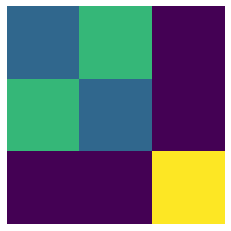

In [17]:
rep.visualize()

In [8]:
import matplotlib.pyplot as plt
#plt.savefig(f"{G}_{rep}_soln2.pdf", bbox_inches="tight")

In [163]:
#Q

sparsifying basis:   0%|          | 0/1000 [00:00<?, ?it/s]

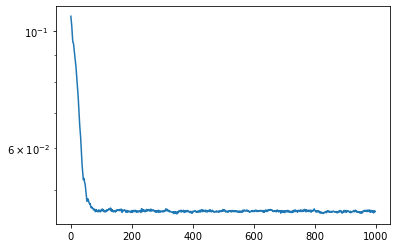

In [30]:
import jax.numpy as jnp
from jax import device_put
from jax import jit
import jax
import optax
from oil.utils.mytqdm import tqdm
import matplotlib.pyplot as plt

lr=3e-2
W = np.random.randn(Q.shape[-1],Q.shape[-1])
W,_ = np.linalg.qr(W)
opt_init,opt_update = optax.adam(lr)#optax.sgd(3e-3,.9)#optax.adam(lr)
opt_update = jit(opt_update)
opt_state = opt_init(W)  # init stats

def loss(W):
    return jnp.abs(W@Q.T).mean() + .1*(jnp.abs(W.T@W-jnp.eye(W.shape[0]))).mean()+.01*jax.numpy.linalg.slogdet(W)[1]**2

loss_and_grad = jit(jax.value_and_grad(loss))

lossvalues = []
logdets = []
for i in tqdm(range(1000),desc=f'sparsifying basis'):
    lossval, grad = loss_and_grad(W)
    updates, opt_state = opt_update(grad, opt_state, W)
    lossvalues.append(lossval)
    W = optax.apply_updates(W, updates)
    
    #s,ld = jax.numpy.linalg.slogdet(W)
    logdets.append(jnp.linalg.norm(grad))
    
plt.plot(lossvalues)
plt.yscale('log')

In [31]:
((W.T@W-jnp.eye(W.shape[0]))**2).mean()

DeviceArray(0.0001591, dtype=float32)

In [32]:
jnp.linalg.slogdet(W)

(DeviceArray(-1., dtype=float32), DeviceArray(-0.12242764, dtype=float32))

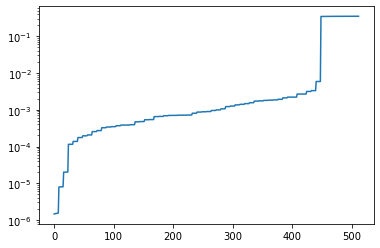

In [33]:
plt.plot(np.sort(np.abs(np.asarray(Q@W.T)).reshape(-1)))
plt.yscale('log')

In [34]:
V=np.copy(np.asarray(Q@W.T))
V[np.abs(V)<1e-2]=0
V[np.abs(V)>1e-2]=1
A = V@(1+np.arange(V.shape[-1]))
assert len(np.unique(A))==V.shape[-1]+1 or len(np.unique(A))==V.shape[-1],np.unique(A)

In [35]:
len(np.unique(A))

8

(-0.5, 7.5, 7.5, -0.5)

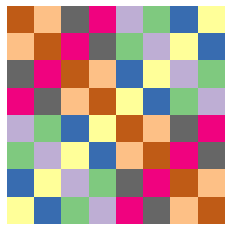

In [50]:
k = int(np.sqrt(A.shape[0]))
plt.imshow(A.reshape((k,k)),cmap='Accent')
plt.axis('off')
#plt.savefig(f"{G}_{rep}_soln.pdf", bbox_inches="tight")

In [13]:
Q.shape

(256, 16)

[ 0.         -0.49805826  0.          0.         -0.49805814  0.
  0.          0.          0.          0.          0.         -0.49805814
  0.          0.         -0.4980582   0.        ]


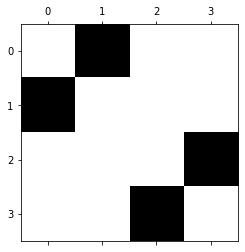

[-0.49805838  0.          0.          0.          0.         -0.49805823
  0.          0.          0.          0.         -0.49805832  0.
  0.          0.          0.         -0.49805826]


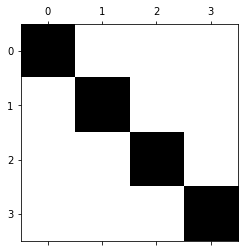

[0.         0.         0.49805826 0.         0.         0.
 0.         0.49805808 0.49805814 0.         0.         0.
 0.         0.49805808 0.         0.        ]


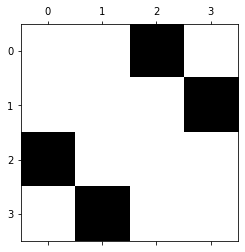

[ 0.          0.          0.         -0.49805838  0.          0.
 -0.4980582   0.          0.         -0.49805814  0.          0.
 -0.49805823  0.          0.          0.        ]


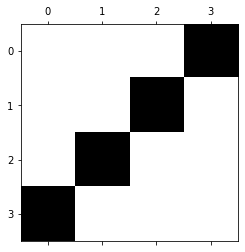

In [80]:
V=np.copy(np.asarray(Q@W.T))
for i in range(V.shape[-1]):
    M = np.copy(V[:,i])
    M[np.abs(M)<1e-3]=0
    print(M.reshape)
    #M[np.abs(M)>1e-3]=1
    #print(M.reshape(8,8))
    plt.spy(M.reshape(4,4))
    plt.show()

In [50]:
V.shape

(64, 8)

In [ ]:
def sparsify(Q,lr=1e-2):
    W = np.random.randn(C.shape[-1],r)
    W /= np.sqrt((W**2).sum(0,keepdims=True))

    opt_init,opt_update = optax.sgd(lr,.9)#optax.adam(lr)#optax.sgd(3e-3,.9)#optax.adam(lr)
    opt_state = opt_init(W)  # init stats

    def loss(W):
        return ((C@W)**2).sum()/2

    loss_and_grad = jit(jax.value_and_grad(loss))

    #lossvalues = []
    for i in tqdm(range(1000),desc=f'Krylov Solving for Equivariant Subspace r<={r}'):
        lossval, grad = loss_and_grad(W)
        updates, opt_state = opt_update(grad, opt_state, W)
        W = optax.apply_updates(W, updates)
        W /= jnp.sqrt((W**2).sum(0,keepdims=True))
        #lossvalues.append(lossval)
        if lossval <tol**2: break
        if lossval>1e2 and i>100: # Solve diverged due to too high learning rate
            logging.warning(f"Constraint solving diverged, trying lower learning rate {lr/3:.2e}")
            return krylov_constraint_solve_upto_r(C,r,tol,lr=lr/3)
    if lossval>1e-1: # Failed to converge means subspace has dimension 0 
        W*=0
    # Orthogonalize solution at the end
    U,S,VT = np.linalg.svd(np.array(W),full_matrices=False)
    rank = (S>tol).sum()
    Q = U[:,:rank]
    return device_put(Q)

In [3]:
from emlp_jax.datasets import BrokenRubiksCube,BrokenRubiksCube2x2,InvertedCube
from emlp_jax.mlp import uniform_allocation

In [16]:
G =O13()

In [20]:
T(4)(G).symmetric_basis().shape#reshape(4,4)

(256, 3)

In [13]:
G = Cube()

In [9]:
np.arange(24)[G.perms[0]].reshape(6,4)

AttributeError: 'RubiksCube' object has no attribute 'perms'

In [18]:
T(4)(Cube()).symmetric_basis().shape

(1296, 60)

In [8]:
np.roll(np.arange(4),1)

array([3, 0, 1, 2])

In [3]:
ds =InvertedCube()

In [4]:
ds.X.shape

(2, 36)

In [4]:
W_rep = T(1)(Cube())*ds.rep_in(Cube())

In [13]:
#W_rep = W_rep(Cube())

In [14]:
P = W_rep.symmetric_projector()

In [15]:
W = P(np.random.randn(P.shape[-1])).reshape(W_rep.shape)

In [18]:
W.shape

(6, 36)

In [11]:
#ds.X@Q_dense

In [19]:
ds.X@W.T

DeviceArray([[ 4.939117  ,  2.0212417 , -1.6775758 ,  4.899134  ,
               1.2750003 ,  0.87473357],
             [-1.0132487 ,  0.32094163, -2.0643241 , -0.18619199,
              -5.04762   ,  2.4405694 ]], dtype=float32)

In [36]:
T(1)(Cube()).symmetric_basis().shape

(6, 1)

In [37]:
T(2)(Cube()).symmetric_basis().shape

(36, 3)

In [1]:
import jax
#jax.config.update('jax_platform_name', 'cpu')
import numpy as np
import jax.numpy as jnp
from emlp_jax.equivariant_subspaces import T
from emlp_jax.groups import *
from emlp_jax.datasets import BrokenRubiksCube,InvertedCube
from emlp_jax.mlp import uniform_allocation

In [41]:
G = Cube()
repin = 6*T(1)(G)
rep = (138*T(0)+23*T(1))(G)
repin=rep
rep = 2*T(0)(G)

In [42]:
rep_W = rep*repin.T

In [43]:
g = G.sample()

In [44]:
Q = rep_W.symmetric_basis()

In [45]:
vec_W = Q@np.random.randn(Q.shape[-1])

In [46]:
W = vec_W.reshape(rep_W.shape)

In [47]:
W.shape

(2, 276)

In [48]:
gWginv = rep.rho(g)@(W@repin.rho(jnp.linalg.inv(g)))

In [49]:
jnp.abs(gWginv-W).max()

DeviceArray(3.9339066e-06, dtype=float32)